### Build chatbot using system message

In [2]:
from datetime import datetime
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

system_prompt = f"""
You are a helpful AI Assistant that can use web search tool(tavily ai api).
You should always answer in same language as user's ask.
When use ask about the information that you can't answer, you should call the web search tool.

web search tool is useful when:
- real-time info
- local specialized info
- metric related info

you should use web search tool with the guideline below:
- Extract the user query's intent and rephrase the prompt into appropriate search query
- web search tool(Tavily AI API) can deal with sentence query. 
you don't need to limit your querying ability to generating keyword only query.
- Today is {datetime.now().strftime("%Y-%m-%d")}
"""

prompt = ChatPromptTemplate([
    SystemMessagePromptTemplate.from_template(system_prompt),
    HumanMessagePromptTemplate.from_template("{input}")
])

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

search = TavilySearchResults(max_results=5)

tools = [search]
llm_with_tools = llm.bind_tools(tools)

chain = prompt | llm_with_tools

result = chain.invoke({"input": "대한민국 축구국가대표팀 명단 알려줘"})
print(result)

content='' additional_kwargs={'tool_calls': [{'id': 'call_8XvjYBotALaaf2wzZUQNrmwA', 'function': {'arguments': '{"query":"대한민국 축구 국가대표팀 2024 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 232, 'total_tokens': 261, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3dab1723-6f49-4989-af36-94c6d2dcbbd8-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '대한민국 축구 국가대표팀 2024 명단'}, 'id': 'call_8XvjYBotALaaf2wzZUQNrmwA', 'type': 'tool_call'}] usage_metadata={'input_tokens': 232, 'output_tokens': 29, 'total_tokens': 261, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [3]:
print(result.additional_kwargs)

{'tool_calls': [{'id': 'call_8XvjYBotALaaf2wzZUQNrmwA', 'function': {'arguments': '{"query":"대한민국 축구 국가대표팀 2024 명단"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}


In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [chain.invoke(state["messages"])]}


tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = graph_builder.compile()

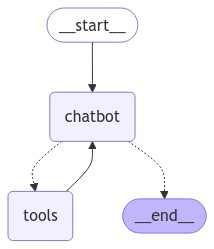

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

User:  대한민국 축구 국가대표팀 명단 알려줘


================================ Human Message =================================

대한민국 축구 국가대표팀 명단 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SQct6yhxhqghYQb6eVSDC0L8)
 Call ID: call_SQct6yhxhqghYQb6eVSDC0L8
  Args:
    query: 대한민국 축구 국가대표팀 2024 명단
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://brasshun.tistory.com/entry/대한민국-축구-국가대표팀-9월-A매치-명단-발표-홍명보-감독의-선택은", "content": "안녕하세요, 축구 팬 여러분! 대한민국 축구 국가대표팀의 새로운 여정이 곧 시작됩니다. 2024년 9월, 홍명보 감독이 이끄는 대한민국 대표팀은 2026년 북중미 월드컵 아시아지역 3차 예선을 준비하고 있습니다. 오늘 발표된 대표팀 명단과 함께, 이번 예선에 대한 기대와 전망을 알아보겠습니다"}, {"url": "https://www.msn.com/ko-kr/sports/other/남자-축구-대표팀-2024-아시안컵-최종명단-발표-손흥민-황희찬-이강인-등-26명/ar-AA1mkE3X", "content": "[문화뉴스 이하온 기자] 2023년 12월 28일(목), 2024 AFC 카타르 아시안컵에 출전할 대한민국 남자 축구 국가대표팀 최종명단이 발표되었다.위르겐"}, {"url": "https://sports.news.nate.com/view/20241104n12738", "content": 

### Custom Tool

In [11]:
import os
from tavily import TavilyClient

@tool
def search_news(keyword: str) -> str:
    """Collect recent news for given query."""
    tavily_client = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])
    search_results = tavily_client.search(query=keyword, topic="news", days=30)
    return search_results

In [12]:
help(TavilyClient)

Help on class TavilyClient in module tavily.tavily:

class TavilyClient(builtins.object)
 |  TavilyClient(api_key: Optional[str] = None)
 |  
 |  Tavily API client class.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, api_key: Optional[str] = None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  extract(self, urls: Union[List[str], str], **kwargs) -> dict
 |      Combined extract method.
 |  
 |  get_company_info(self, query: str, search_depth: Literal['basic', 'advanced'] = 'advanced', max_results: int = 5) -> Sequence[dict]
 |      Company information search method. Search depth is advanced by default to get the best answer.
 |  
 |  get_search_context(self, query: str, search_depth: Literal['basic', 'advanced'] = 'basic', topic: Literal['general', 'news'] = 'general', days: int = 3, max_results: int = 5, include_domains: Sequence[str] = None, exclude_domains: Sequence[str] = None, max_tokens: int = 4000, **kwargs) -> str
 |      Get the search

In [13]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

tools = [search_news]
llm_with_tools = llm.bind_tools(tools)

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


tool_node = ToolNode(tools=tools)

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)

graph = graph_builder.compile()

In [17]:
events = graph.stream(
    {"messages": [("user", input("User: "))]}, config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

User:  AI Agent의 발전 방향과 적용 사례에 대해서 알려줘


================================ Human Message =================================

AI Agent의 발전 방향과 적용 사례에 대해서 알려줘
================================== Ai Message ==================================
Tool Calls:
  search_news (call_9i4HjhD6EHONj6dyLClP3LCV)
 Call ID: call_9i4HjhD6EHONj6dyLClP3LCV
  Args:
    keyword: AI Agent 발전 방향
  search_news (call_YP8UcBWeLXlhH11sOAaBfTOG)
 Call ID: call_YP8UcBWeLXlhH11sOAaBfTOG
  Args:
    keyword: AI Agent 적용 사례
================================= Tool Message =================================
Name: search_news

{"query": "AI Agent 적용 사례", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.forbes.com/sites/libertbarry/2024/11/22/beyond-moonshots-ai-agents-will-come-to-earth-in-2025/", "title": "Beyond Moonshots: AI Agents Will Come To Earth In 2025 - Forbes", "score": 0.9938309, "published_date": "Fri, 22 Nov 2024 22:27:50 GMT", "content": "Examples like these showcase how AI agents can subtly transform essential